# PROJET SEATTLE ENERGY BENCHMARKING
## Notebook 03 : analyse bivariée 
relation  ave  la Variable cibl

---

### Identité du document
* **Statut :** Phase 1 (exploration & prototypage)
* **Date de création :** 04 Janvier 2026
* **Dernière mise à jour :** 04 Janvier 2026
* **Dépendances notebooks**:0; 1; 2e

### DescriptionCe notebook constitue le cœur de l’analyse exploratoire prédictive (EDA) du projet. Il s’appuie sur les notebooks précédents pour passer d’une analyse descriptive à une analyse orientée modélisation, en identifiant les variables ayant un réel pouvoir explicatif et prédictif sur la variable cible TotalGHGEmissions.


### Objectifs principau
x1. Identifier les variables présentant la plus forte relation avec TotalGHGEmissions.

2. Analyser la nature des relations (linéaires, non linéaires, monotones).

3. Évaluer l’impact des variables catégorielles (types de bâtiments, quartiers) sur les niveaux d’émissions.
4. Détecter la multicolinéarité et les prédicteurs redondants.

Réaliser une sélection préliminaire des variables en écartant celles sans pouvoir prédictif.

### Dépendances critiques
* `hydra` : Gestion de la configuration.
* `src.utils` & `src.data` : Modules internes de support.

### LIVRABLE
S1. Notebook d’analyse bivariée complété : notebooks/3_bivariate_analysis.ipynb.
2. Matrice de corrélation annotée : reports/Correlation_Matrix.csv.
3. Classement des variables selon leur pouvoir prédictif (Top 20+) : reports/Feature_Ranking.csv.
4. Liste des variables à éliminer avec justification : reports/Variables_to_Drop.md.
5. Résultats des tests statistiques (ANOVA, Kruskal-Wallis, etc.) : reports/Statistical_Tests_Results.csv.
6. Ensemble de visualisations sauvegardées (≈25–30 graphiques) :
7. Scatter plots des 15 relations les plus corrélées à TotalGHGEmissions

# SECTION 1: Corrélations avec la cible - Vue d'ensemble

## Importation des bibliothéques nécessaires

In [1]:
import logging
import pandas as pd
from pathlib import Path


from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().parent
SRC_PATH = PROJECT_ROOT / "src"

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

from data.load_data import load_data_raw
from data.clean_data import run_cleaning_pipeline
from utils.config_loader import load_config
 

In [2]:

cfg = load_config()
df_raw = load_data_raw(cfg)
df_cleaned = run_cleaning_pipeline(df_raw, cfg)


   [Audit] section_0 : -1752 lignes exportées vers section_0_removed.csv
   [Audit] section_1 : -119 lignes exportées vers section_1_removed.csv
   [Audit] section_2 : -47 lignes exportées vers section_2_removed.csv
   [Audit] section_3 : -63 lignes exportées vers section_3_removed.csv


In [3]:
df_cleaned

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity,IsMixedUse,Has_EnergyStarScore,IsZeroFloorReported,IsAggregatedCampus
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,12764.529300,1.276453e+06,False,Compliant,249.98,2.83,0,1,0,0
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,51450.816410,5.145082e+06,False,Compliant,295.86,2.86,1,1,0,0
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,18112.130860,1.811213e+06,False,Compliant,286.43,4.67,0,1,0,0
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,88039.984380,8.803998e+06,False,Compliant,505.01,2.88,1,1,0,0
5,9,2016,Nonresidential COS,Other,West Precinct,810 Virginia St,Seattle,WA,98101.0,0660000560,...,47151.816410,4.715182e+06,False,Compliant,301.81,3.10,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,50221,2016,Nonresidential COS,Other,High Point Community Center,6920 34th Ave SW,Seattle,WA,98115.0,2524039059,...,2997.199951,2.997200e+05,False,Compliant,20.33,1.11,0,0,0,0
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,98115.0,3558300000,...,5537.299805,5.537300e+05,False,Compliant,32.17,2.01,0,0,0,0
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,98115.0,1794501150,...,39737.390630,3.973739e+06,False,Compliant,223.54,16.99,1,0,0,0
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,98109.0,7883603155,...,3706.010010,3.706010e+05,False,Compliant,22.11,1.57,1,0,0,0


## Analyses :

## 1°) Calcul des corrélations de Pearson (TotalGHGEmissions vs chaque variable numérique)

In [4]:
import pandas as pd

# Sélection des variables numériques
df_num = df_cleaned.select_dtypes(include='number')

# Vérification que la variable cible existe
if 'TotalGHGEmissions' not in df_num.columns:
    raise ValueError("La variable 'TotalGHGEmissions' n'existe pas ou n'est pas numérique.")

# Calcul des corrélations de Pearson avec la cible
corr_pearson = (
    df_num
    .corr(method='pearson')['TotalGHGEmissions']
    .drop('TotalGHGEmissions')  # on enlève l'auto-corrélation
    .sort_values(ascending=False)
)

# Conversion en DataFrame pour une meilleure lisibilité
corr_pearson_df = corr_pearson.reset_index()
corr_pearson_df.columns = ['Variable', 'Corrélation de Pearson']

# Affichage
corr_pearson_df



,Variable,Corrélation de Pearson
0,SiteEnergyUseWN(kBtu),0.918968
1,SiteEnergyUse(kBtu),0.918537
2,SteamUse(kBtu),0.818467
3,Electricity(kWh),0.743491
4,Electricity(kBtu),0.743491
5,NaturalGas(therms),0.609614
6,NaturalGas(kBtu),0.609614
7,LargestPropertyUseTypeGFA,0.531293
8,PropertyGFABuilding(s),0.492007
9,PropertyGFATotal,0.445023


## 2°) Calcul des corrélations de Spearman (pour relations monotones non-linéaires)

In [5]:
import pandas as pd

# Sélection des variables numériques
df_num = df_cleaned.select_dtypes(include='number')

# Vérification de l'existence de la variable cible
if 'TotalGHGEmissions' not in df_num.columns:
    raise ValueError("La variable 'TotalGHGEmissions' n'existe pas ou n'est pas numérique.")

# Calcul des corrélations de Spearman
corr_spearman = (
    df_num
    .corr(method='spearman')['TotalGHGEmissions']
    .drop('TotalGHGEmissions')  # suppression de l'auto-corrélation
    .sort_values(ascending=False)
)

# Mise en DataFrame pour lisibilité
corr_spearman_df = corr_spearman.reset_index()
corr_spearman_df.columns = ['Variable', 'Corrélation de Spearman']

# Affichage
corr_spearman_df


,Variable,Corrélation de Spearman
0,SiteEnergyUseWN(kBtu),0.866495
1,SiteEnergyUse(kBtu),0.852014
2,NaturalGas(kBtu),0.726352
3,NaturalGas(therms),0.726352
4,GHGEmissionsIntensity,0.715730
5,SiteEUIWN(kBtu/sf),0.665560
6,SiteEUI(kBtu/sf),0.659003
7,Electricity(kWh),0.622340
8,Electricity(kBtu),0.622340
9,PropertyGFABuilding(s),0.552785


In [ ]:
## 3°) Tri décroissant par valeur absolue de corrélation

In [6]:
import pandas as pd

# Sélection des variables numériques
df_num = df_cleaned.select_dtypes(include='number')

# Vérification de la variable cible
target = 'TotalGHGEmissions'
if target not in df_num.columns:
    raise ValueError(f"La variable '{target}' n'existe pas ou n'est pas numérique.")

# Calcul des corrélations
corr_pearson = df_num.corr(method='pearson')[target]
corr_spearman = df_num.corr(method='spearman')[target]

# Construction du tableau récapitulatif
corr_df = (
    pd.DataFrame({
        'Pearson': corr_pearson,
        'Spearman': corr_spearman
    })
    .drop(index=target)  # suppression auto-corrélation
)

# Ajout des valeurs absolues
corr_df['|Pearson|'] = corr_df['Pearson'].abs()
corr_df['|Spearman|'] = corr_df['Spearman'].abs()

# Tri décroissant selon la corrélation absolue maximale
corr_df_sorted = corr_df.sort_values(
    by=['|Spearman|', '|Pearson|'],
    ascending=False
)

# Affichage
corr_df_sorted


,Pearson,Spearman,|Pearson|,|Spearman|
SiteEnergyUseWN(kBtu),0.918968,0.866495,0.918968,0.866495
SiteEnergyUse(kBtu),0.918537,0.852014,0.918537,0.852014
NaturalGas(therms),0.609614,0.726352,0.609614,0.726352
NaturalGas(kBtu),0.609614,0.726352,0.609614,0.726352
GHGEmissionsIntensity,0.338914,0.715730,0.338914,0.715730
SiteEUIWN(kBtu/sf),0.295917,0.665560,0.295917,0.665560
SiteEUI(kBtu/sf),0.297356,0.659003,0.297356,0.659003
Electricity(kWh),0.743491,0.622340,0.743491,0.622340
Electricity(kBtu),0.743491,0.622340,0.743491,0.622340
PropertyGFABuilding(s),0.492007,0.552785,0.492007,0.552785


In [ ]:
## 4°)Visualisation : barplot horizontal des corrélations (top 20)

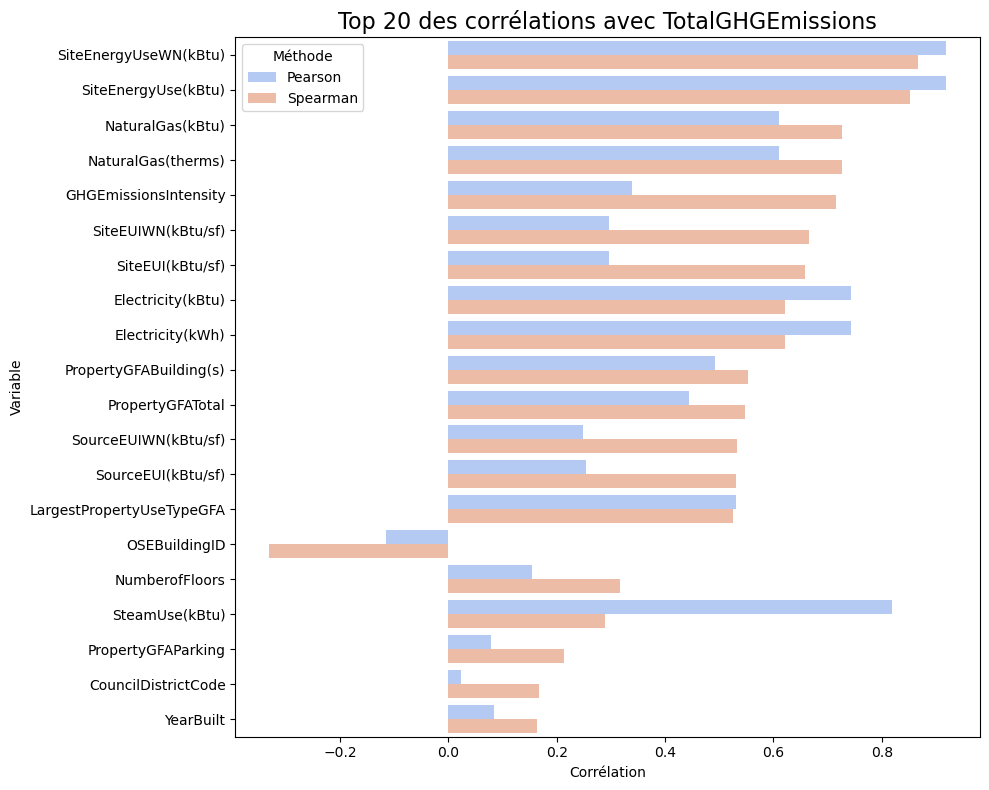

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sélection des variables numériques
df_num = df_cleaned.select_dtypes(include='number')

target = 'TotalGHGEmissions'
if target not in df_num.columns:
    raise ValueError(f"La variable '{target}' n'existe pas ou n'est pas numérique.")

# Calcul corrélations
corr_pearson = df_num.corr(method='pearson')[target].drop(target)
corr_spearman = df_num.corr(method='spearman')[target].drop(target)

# Création DataFrame pour tri par valeur absolue de Spearman
corr_df = pd.DataFrame({
    'Variable': corr_pearson.index,
    'Pearson': corr_pearson.values,
    'Spearman': corr_spearman.values
})
corr_df['|Spearman|'] = corr_df['Spearman'].abs()

# Sélection top 20 par valeur absolue Spearman
top_corr = corr_df.sort_values('|Spearman|', ascending=False).head(20)

# Mise en forme pour seaborn
top_corr_melted = top_corr.melt(id_vars='Variable', value_vars=['Pearson', 'Spearman'],
                                var_name='Méthode', value_name='Corrélation')

# Plot horizontal
plt.figure(figsize=(10,8))
sns.barplot(
    data=top_corr_melted,
    y='Variable',
    x='Corrélation',
    hue='Méthode',
    palette='coolwarm'
)
plt.title('Top 20 des corrélations avec TotalGHGEmissions', fontsize=16)
plt.xlabel('Corrélation')
plt.ylabel('Variable')
plt.legend(title='Méthode')
plt.tight_layout()
plt.show()


## Interprétations : 

**Rappel :**

**Pearson** mesure la relation linéaire entre deux variables (sensible aux valeurs aberrantes).

**Spearman** mesure la relation monotone (robuste aux valeurs aberrantes, basé sur les rangs).

Interprétation : si les coefficients de Pearson et Spearman sont très différents → la relation est probablement non linéaire.

# SECTION 2:  Relations avec les consommations énergétiques

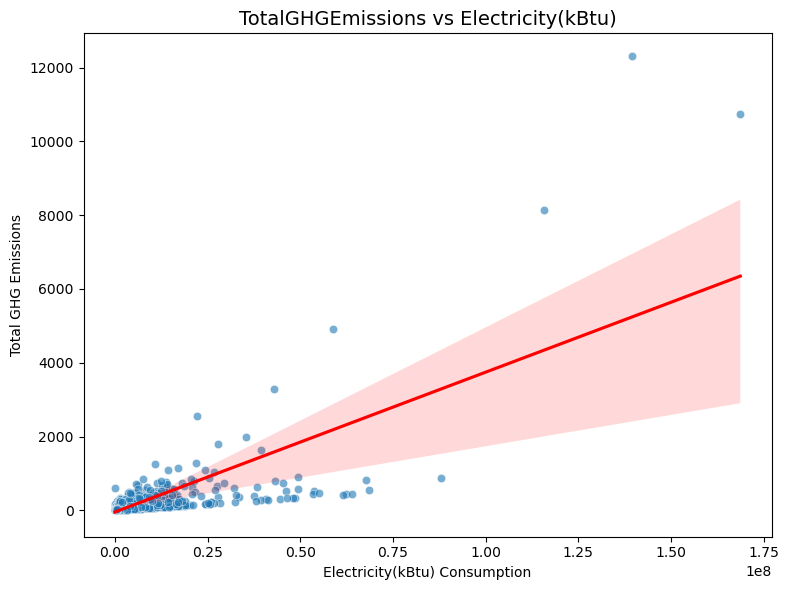

R² (TotalGHGEmissions explained by Electricity alone) : 0.553 (55.3%)


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Sélection des variables
x = df_cleaned[['Electricity(kBtu)']].dropna()
y = df_cleaned.loc[x.index, 'TotalGHGEmissions']

# Scatterplot + regression line
plt.figure(figsize=(8,6))
sns.scatterplot(x='Electricity(kBtu)', y='TotalGHGEmissions', data=df_cleaned, alpha=0.6)
sns.regplot(x='Electricity(kBtu)', y='TotalGHGEmissions', data=df_cleaned, scatter=False, color='red')
plt.title('TotalGHGEmissions vs Electricity(kBtu)', fontsize=14)
plt.xlabel('Electricity(kBtu) Consumption')
plt.ylabel('Total GHG Emissions')
plt.tight_layout()
plt.show()

# Calcul R²
model = LinearRegression()
model.fit(x, y)
r2 = model.score(x, y)
print(f"R² (TotalGHGEmissions explained by Electricity alone) : {r2:.3f} ({r2*100:.1f}%)")


In [ ]:
## 2°)Scatterplot + régression : NaturalGas(kBtu) vs TotalGHGEmissions

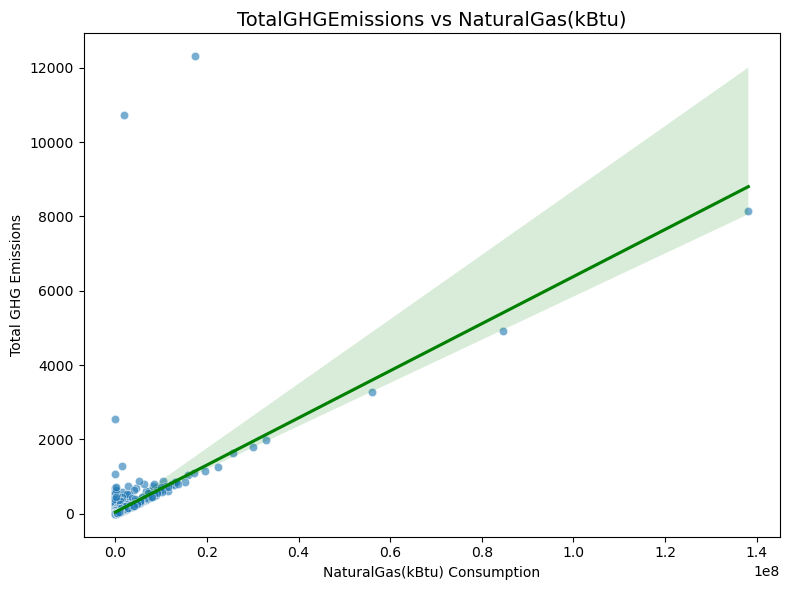

R² (TotalGHGEmissions explained by NaturalGas(kBtu) alone) : 0.372 (37.2%)


In [10]:
# Sélection des variables
x_ng = df_cleaned[['NaturalGas(kBtu)']].dropna()
y_ng = df_cleaned.loc[x_ng.index, 'TotalGHGEmissions']

# Scatterplot + regression line
plt.figure(figsize=(8,6))
sns.scatterplot(x='NaturalGas(kBtu)', y='TotalGHGEmissions', data=df_cleaned, alpha=0.6)
sns.regplot(x='NaturalGas(kBtu)', y='TotalGHGEmissions', data=df_cleaned, scatter=False, color='green')
plt.title('TotalGHGEmissions vs NaturalGas(kBtu)', fontsize=14)
plt.xlabel('NaturalGas(kBtu) Consumption')
plt.ylabel('Total GHG Emissions')
plt.tight_layout()
plt.show()

# Calcul R²
model_ng = LinearRegression()
model_ng.fit(x_ng, y_ng)
r2_ng = model_ng.score(x_ng, y_ng)
print(f"R² (TotalGHGEmissions explained by NaturalGas(kBtu) alone) : {r2_ng:.3f} ({r2_ng*100:.1f}%)")


In [ ]:
## 3°)Scatterplot + régression : SteamUse(kBtu) vs TotalGHGEmissions

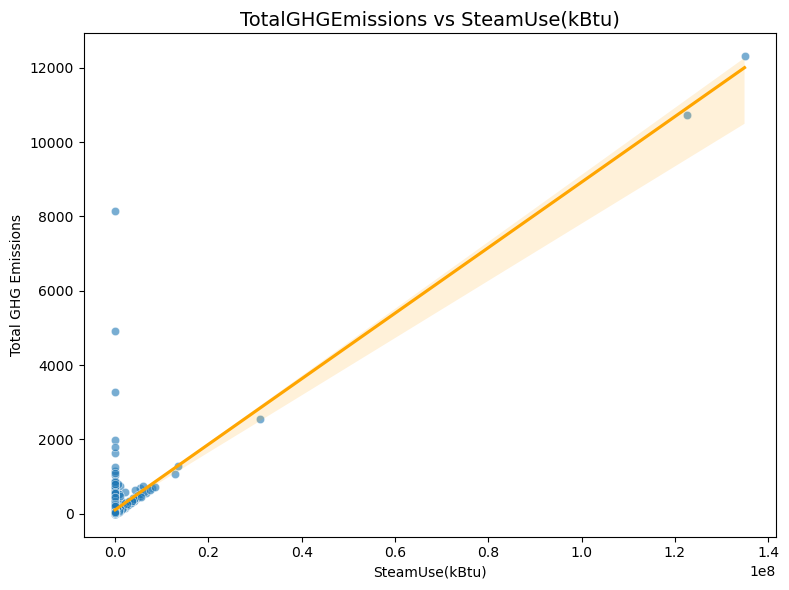

R² (TotalGHGEmissions explained by SteamUse(kBtu)alone) : 0.670 (67.0%)


In [11]:
# Sélection des variables
x_steam = df_cleaned[['SteamUse(kBtu)']].dropna()
y_steam = df_cleaned.loc[x_steam.index, 'TotalGHGEmissions']

# Scatterplot + regression line
plt.figure(figsize=(8,6))
sns.scatterplot(x='SteamUse(kBtu)', y='TotalGHGEmissions', data=df_cleaned, alpha=0.6)
sns.regplot(x='SteamUse(kBtu)', y='TotalGHGEmissions', data=df_cleaned, scatter=False, color='orange')
plt.title('TotalGHGEmissions vs SteamUse(kBtu)', fontsize=14)
plt.xlabel('SteamUse(kBtu)')
plt.ylabel('Total GHG Emissions')
plt.tight_layout()
plt.show()

# Calcul R²
model_steam = LinearRegression()
model_steam.fit(x_steam, y_steam)
r2_steam = model_steam.score(x_steam, y_steam)
print(f"R² (TotalGHGEmissions explained by SteamUse(kBtu)alone) : {r2_steam:.3f} ({r2_steam*100:.1f}%)")


In [ ]:
## 4°) Comparaison rapide des pentes

In [12]:
from sklearn.linear_model import LinearRegression

# Liste des variables énergétiques
energy_vars = ['Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)']

# Stockage des pentes
slopes = {}

for var in energy_vars:
    # Retirer les NaN
    x = df_cleaned[[var]].dropna()
    y = df_cleaned.loc[x.index, 'TotalGHGEmissions']
    
    # Modèle linéaire
    model = LinearRegression()
    model.fit(x, y)
    
    # Stocker la pente
    slopes[var] = model.coef_[0]

# Affichage des pentes
print("Pentes des consommations énergétiques vs TotalGHGEmissions :")
for var, slope in slopes.items():
    print(f"{var:10s} : {slope:.10f}")


Pentes des consommations énergétiques vs TotalGHGEmissions :
Electricity(kBtu) : 0.0000378951
NaturalGas(kBtu) : 0.0000633411
SteamUse(kBtu) : 0.0000881314


In [ ]:
## Résumé sur les résultats attendus de cette section

# SECTION 3:  Relations avec les consommations énergétiques

In [ ]:
## 1°) PropertyGFATotal vs TotalGHGEmissions

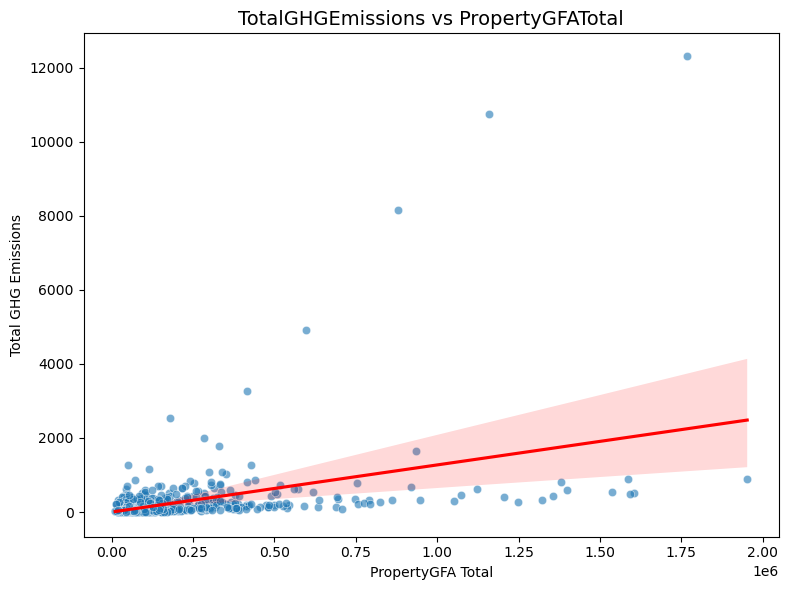

R² : 0.198045 (19.80%)
Pente : 0.001272
Relation faible ou modérée


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Nettoyage des NaN
x = df_cleaned[['PropertyGFATotal']].dropna()
y = df_cleaned.loc[x.index, 'TotalGHGEmissions']

# Scatterplot + regression line
plt.figure(figsize=(8,6))
sns.scatterplot(x='PropertyGFATotal', y='TotalGHGEmissions', data=df_cleaned, alpha=0.6)
sns.regplot(x='PropertyGFATotal', y='TotalGHGEmissions', data=df_cleaned, scatter=False, color='red')
plt.title('TotalGHGEmissions vs PropertyGFATotal', fontsize=14)
plt.xlabel('PropertyGFA Total')
plt.ylabel('Total GHG Emissions')
plt.tight_layout()
plt.show()

# Calcul R²
model_gfa = LinearRegression()
model_gfa.fit(x, y)
r2_gfa = model_gfa.score(x, y)
slope_gfa = model_gfa.coef_[0]

print(f"R² : {r2_gfa:.6f} ({r2_gfa*100:.2f}%)")
print(f"Pente : {slope_gfa:.6f}")

# Observation
if r2_gfa > 0.5:
    print("Relation forte attendue : plus grand = plus d'émissions")
else:
    print("Relation faible ou modérée")


## 2°)PropertyGFATotal vs GHGEmissionsIntensity

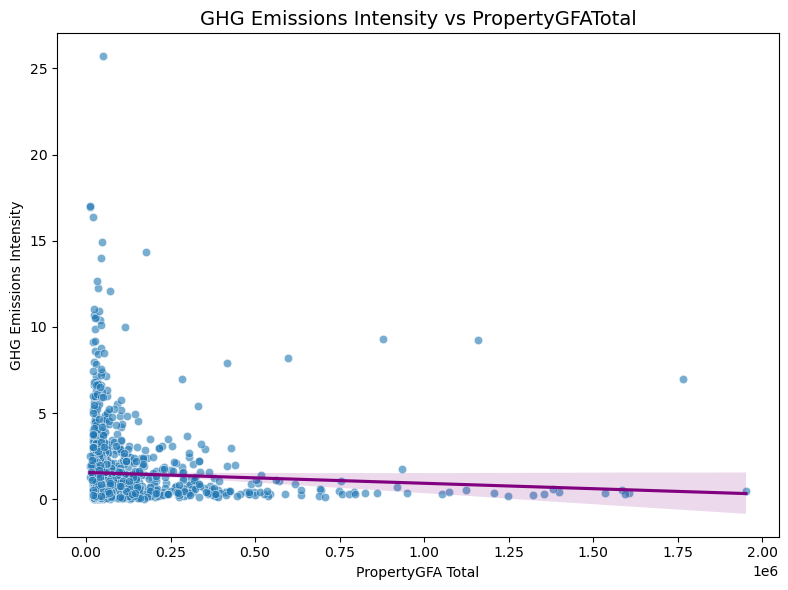

Corrélation PropertyGFATotal vs GHGEmissionsIntensity : -0.057038


In [14]:
# GHG Emissions Intensity = TotalGHGEmissions / PropertyGFATotal
x_int = df_cleaned[['PropertyGFATotal']].dropna()
y_int = df_cleaned.loc[x_int.index, 'GHGEmissionsIntensity']

# Scatterplot
plt.figure(figsize=(8,6))
sns.scatterplot(x='PropertyGFATotal', y='GHGEmissionsIntensity', data=df_cleaned, alpha=0.6)
sns.regplot(x='PropertyGFATotal', y='GHGEmissionsIntensity', data=df_cleaned, scatter=False, color='purple')
plt.title('GHG Emissions Intensity vs PropertyGFATotal', fontsize=14)
plt.xlabel('PropertyGFA Total')
plt.ylabel('GHG Emissions Intensity')
plt.tight_layout()
plt.show()

# Corrélation
corr_intensity = x_int.join(y_int).corr(method='pearson').iloc[0,1]
print(f"Corrélation PropertyGFATotal vs GHGEmissionsIntensity : {corr_intensity:.6f}")


## 3°)YearBuilt vs TotalGHGEmissions

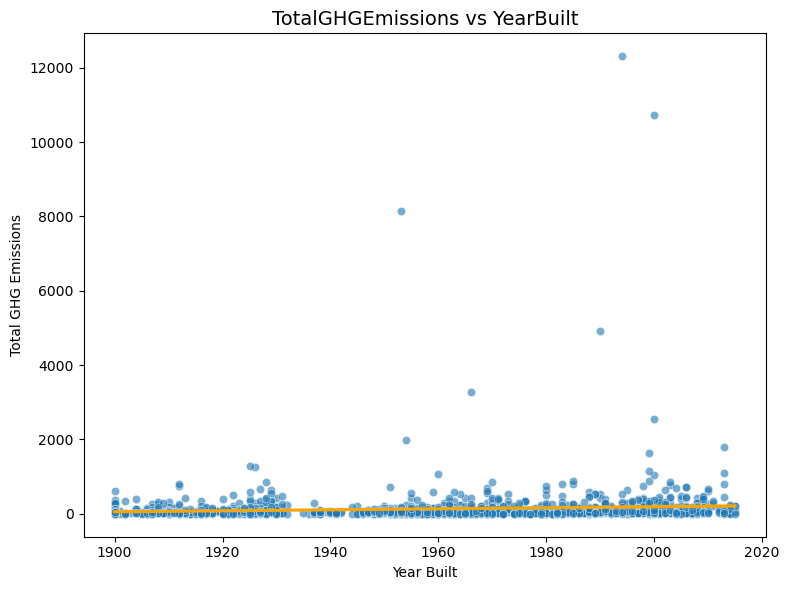

Corrélation YearBuilt vs TotalGHGEmissions : 0.083933
Nuance : plus vieux bâtiments souvent plus petits → considérer analyse multiple ou normalisation par PropertyGFATotal


In [15]:
# Nettoyage des NaN
x_year = df_cleaned[['YearBuilt']].dropna()
y_year = df_cleaned.loc[x_year.index, 'TotalGHGEmissions']

# Scatterplot + regression line
plt.figure(figsize=(8,6))
sns.scatterplot(x='YearBuilt', y='TotalGHGEmissions', data=df_cleaned, alpha=0.6)
sns.regplot(x='YearBuilt', y='TotalGHGEmissions', data=df_cleaned, scatter=False, color='orange')
plt.title('TotalGHGEmissions vs YearBuilt', fontsize=14)
plt.xlabel('Year Built')
plt.ylabel('Total GHG Emissions')
plt.tight_layout()
plt.show()

# Corrélation
corr_year = x_year.join(y_year).corr(method='pearson').iloc[0,1]
print(f"Corrélation YearBuilt vs TotalGHGEmissions : {corr_year:.6f}")

# Remarque : contrôler par la taille
print("Nuance : plus vieux bâtiments souvent plus petits → considérer analyse multiple ou normalisation par PropertyGFATotal")


## 4°)NumberofFloors vs TotalGHGEmissions

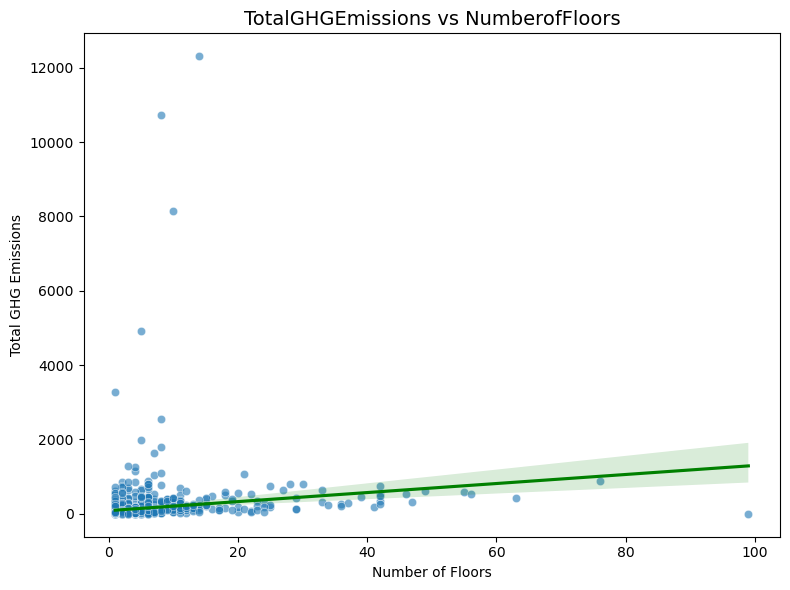

Corrélation NumberofFloors vs TotalGHGEmissions : 0.154428


In [16]:
# Nettoyage
x_floor = df_cleaned[['NumberofFloors']].dropna()
y_floor = df_cleaned.loc[x_floor.index, 'TotalGHGEmissions']

# Scatterplot + regression line
plt.figure(figsize=(8,6))
sns.scatterplot(x='NumberofFloors', y='TotalGHGEmissions', data=df_cleaned, alpha=0.6)
sns.regplot(x='NumberofFloors', y='TotalGHGEmissions', data=df_cleaned, scatter=False, color='green')
plt.title('TotalGHGEmissions vs NumberofFloors', fontsize=14)
plt.xlabel('Number of Floors')
plt.ylabel('Total GHG Emissions')
plt.tight_layout()
plt.show()

# Corrélation
corr_floor = x_floor.join(y_floor).corr(method='pearson').iloc[0,1]
print(f"Corrélation NumberofFloors vs TotalGHGEmissions : {corr_floor:.6f}")


# Section 4 : Effet du score ENERGYSTAR

## 4.1 Scatterplot (garder uniquement les scores non-NaN)

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


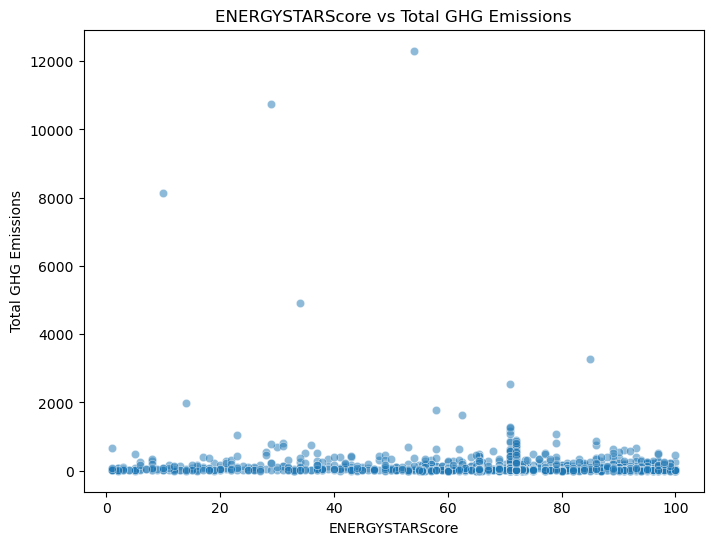

In [29]:
# Filtrer les observations avec ENERGYSTARScore non manquant
df_es = df_cleaned[df_cleaned["ENERGYSTARScore"].notna()]

# Scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_es,
    x="ENERGYSTARScore",
    y="TotalGHGEmissions",
    alpha=0.5
)

plt.title("ENERGYSTARScore vs Total GHG Emissions")
plt.xlabel("ENERGYSTARScore")
plt.ylabel("Total GHG Emissions")
plt.show()


## 4.2 Hypothèse théorique

Hypothèse :
Il existe une relation inverse entre ENERGYSTARScore et TotalGHGEmissions.

_ Score élevé → bâtiment énergétiquement performant

_ Performance énergétique → émissions plus faibles

## 4.3 Corrélations (Pearson & Spearman)

In [18]:
from scipy.stats import pearsonr, spearmanr



In [30]:
# Suppression des NaN sur les deux variables
df_corr = df_cleaned[["ENERGYSTARScore", "TotalGHGEmissions"]].dropna()

# Corrélation de Pearson (relation linéaire)
pearson_corr, pearson_p = pearsonr(
    df_corr["ENERGYSTARScore"],
    df_corr["TotalGHGEmissions"]
)

# Corrélation de Spearman (relation monotone)
spearman_corr, spearman_p = spearmanr(
    df_corr["ENERGYSTARScore"],
    df_corr["TotalGHGEmissions"]
)

pearson_corr, spearman_corr


(-0.07578923375826994, -0.028642171009156742)

**Interprétation attendue :**

Corrélation négative

_ Si Spearman > Pearson → relation monotone mais pas strictement linéaire

_ p-value faible → relation statistiquement significative

## 4.4 Ajout d’une droite de régression

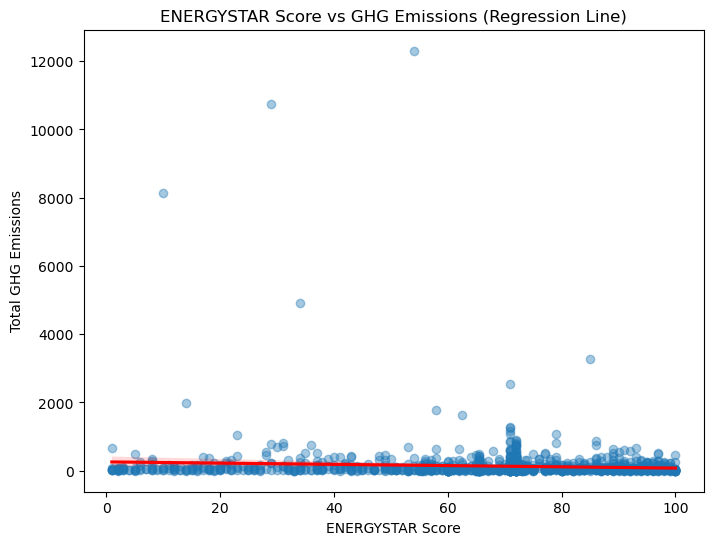

In [31]:
plt.figure(figsize=(8, 6))
sns.regplot(
    data=df_corr,
    x="ENERGYSTARScore",
    y="TotalGHGEmissions",
    scatter_kws={"alpha": 0.4},
    line_kws={"color": "red"}
)

plt.title("ENERGYSTAR Score vs GHG Emissions (Regression Line)")
plt.xlabel("ENERGYSTAR Score")
plt.ylabel("Total GHG Emissions")
plt.show()


## 4.5 Visualisation complémentaire — Binning du score

## Création des bins

In [33]:
import pandas as pd

pd.options.mode.chained_assignment = None  # Désactiver temporairement

bins = [0, 50, 75, 100]
labels = ["0-50", "50-75", "75-100"]
df_cleaned["ENERGYSTAR_bin"] = pd.cut(
    df_cleaned["ENERGYSTARScore"], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

pd.options.mode.chained_assignment = 'warn'  # Réactiver les avertissements

## Boxplot : GHG par bin de score

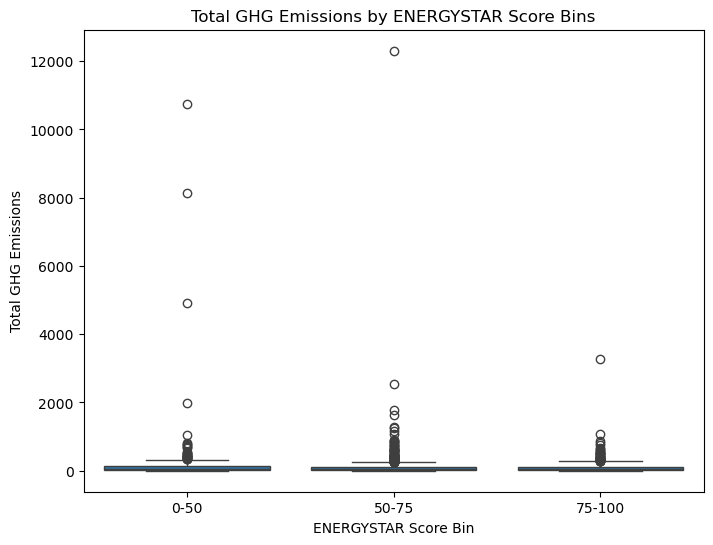

In [34]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df_es,
    x="ENERGYSTAR_bin",
    y="TotalGHGEmissions"
)

plt.title("Total GHG Emissions by ENERGYSTAR Score Bins")
plt.xlabel("ENERGYSTAR Score Bin")
plt.ylabel("Total GHG Emissions")
plt.show()


**Lecture attendue :**

_ Médiane décroissante des émissions quand le score augmente

_ Dispersion plus faible pour les scores élevés

## 4.6 Test statistique — ANOVA

**Question :**
Les moyennes de GHG diffèrent-elles significativement entre les bins ?

In [35]:
from scipy.stats import f_oneway


In [38]:
# Extraire les groupes
groups = [
    df_es[df_es["ENERGYSTAR_bin"] == label]["TotalGHGEmissions"].dropna()
    for label in labels
]

# ANOVA
anova_stat, anova_p = f_oneway(*groups)

anova_stat, anova_p


(10.443615311258117, 3.0409946690726275e-05)

**Interprétation :**

_ p < 0.05 → différences significatives entre groupes

_ Confirme la pertinence du score comme indicateur global

## 4.7 Interprétation globale 

**Corrélation négative significative** → ENERGYSTARScore est un bon indicateur de performance environnementale

_ Mais  attention à la causalité :

_ **Effet causal** : la certification pousse à réduire les émissions

_ **Effet de sélection** : seuls les bâtiments déjà performants cherchent la certification

 Cela limite l’interprétation causale directe.

# SECTION 5 — Analyse par PrimaryPropertyType

## 5.1 Objectif

Identifier les types de bâtiments systématiquement plus ou moins émetteurs

## 5.2 Sélection des 15 types les plus fréquents

In [36]:
top_types = (
    df_raw["PrimaryPropertyType"]
    .value_counts()
    .head(15)
    .index
)

df_type = df_raw[df_raw["PrimaryPropertyType"].isin(top_types)]


## 5.3 Boxplot GHG par type (trié par médiane)

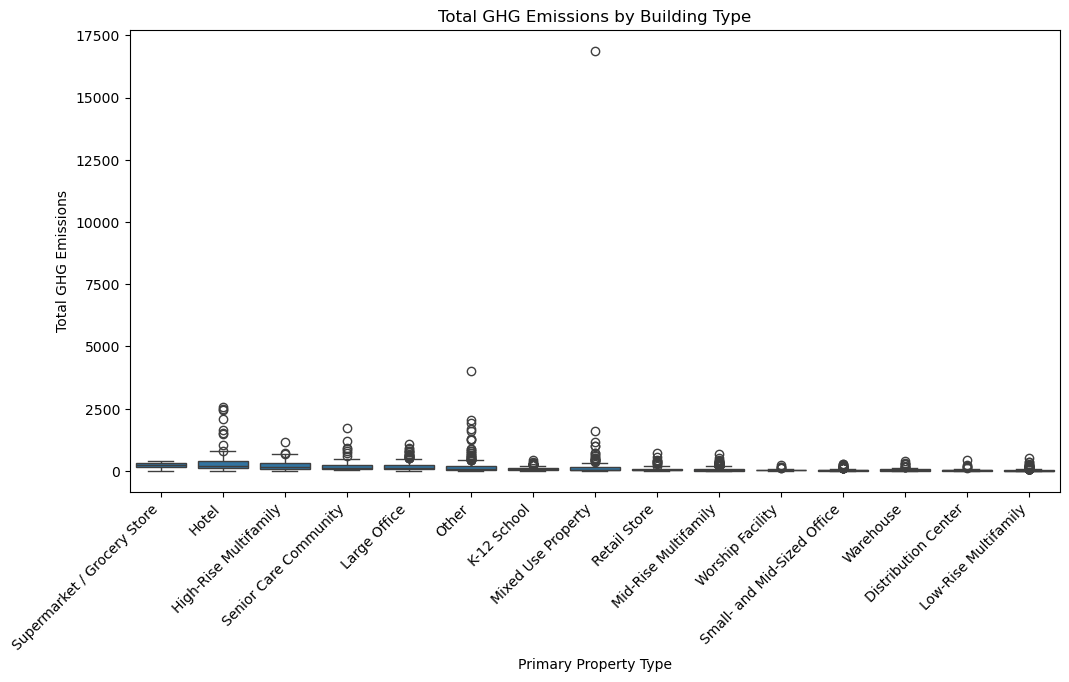

In [40]:
# Calcul des médianes pour l'ordre
order = (
    df_type.groupby("PrimaryPropertyType")["TotalGHGEmissions"]
    .median()
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_type,
    x="PrimaryPropertyType",
    y="TotalGHGEmissions",
    order=order
)

plt.xticks(rotation=45, ha="right")
plt.title("Total GHG Emissions by Building Type")
plt.xlabel("Primary Property Type")
plt.ylabel("Total GHG Emissions")
plt.show()


**Lecture attendue :** Identification claire des high emitters et low emitters

## 5.4 Statistiques descriptives par type

In [41]:
ghg_stats = (
    df_type
    .groupby("PrimaryPropertyType")["TotalGHGEmissions"]
    .agg(["mean", "median", "count"])
    .sort_values("median", ascending=False)
)

ghg_stats


,mean,median,count
PrimaryPropertyType,,,
Supermarket / Grocery Store,222.593750,226.200,40
Hotel,410.882727,208.260,77
High-Rise Multifamily,220.010381,137.940,105
Senior Care Community,269.472222,135.110,45
Large Office,206.412312,131.400,173
Other,191.060703,67.585,256
K-12 School,89.268777,61.250,139
Mixed Use Property,272.934848,44.695,132
Retail Store,88.940330,39.310,91


## 5.5 ANOVA — effet du type sur GHG

In [45]:
order = df_type["PrimaryPropertyType"].dropna().unique()
groups_type = [
    df_type[df_type["PrimaryPropertyType"] == t]["TotalGHGEmissions"].dropna()
    for t in order
]

anova_type_stat, anova_type_p = f_oneway(*groups_type)



_ **Si p < 0.05** → le type de bâtiment influence significativement les émissions.

## 5.6 Tests post-hoc — Tukey HSD

In [46]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [47]:
tukey = pairwise_tukeyhsd(
    endog=df_type["TotalGHGEmissions"],
    groups=df_type["PrimaryPropertyType"],
    alpha=0.05
)

print(tukey)


                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
           group1                      group2            meandiff p-adj lower upper reject
------------------------------------------------------------------------------------------
        Distribution Center       High-Rise Multifamily  169.7847   nan   nan   nan  False
        Distribution Center                       Hotel  360.6571   nan   nan   nan  False
        Distribution Center                 K-12 School   39.0431   nan   nan   nan  False
        Distribution Center                Large Office  156.1867   nan   nan   nan  False
        Distribution Center        Low-Rise Multifamily       nan   nan   nan   nan  False
        Distribution Center        Mid-Rise Multifamily   14.0998   nan   nan   nan  False
        Distribution Center          Mixed Use Property       nan   nan   nan   nan  False
        Distribution Center                       Other   140.835   nan   nan   nan  False

**Objectif :** identifier quels types diffèrent réellement entre eux.

## 5.7 Interprétations attendues

_ **Hospitals / Hotels**
→ émissions élevées
(fonctionnement 24/7, équipements lourds)

_ **Offices**
→ émissions modérées
(occupation diurne)

_ **Retail**
→ forte hétérogénéité
(taille et activité très variables)

## 5.8 Réflexion finale — Effet taille

Les différences viennent-elles du type ou de la taille moyenne ?

## Analyse avec GHGEmissionsIntensity

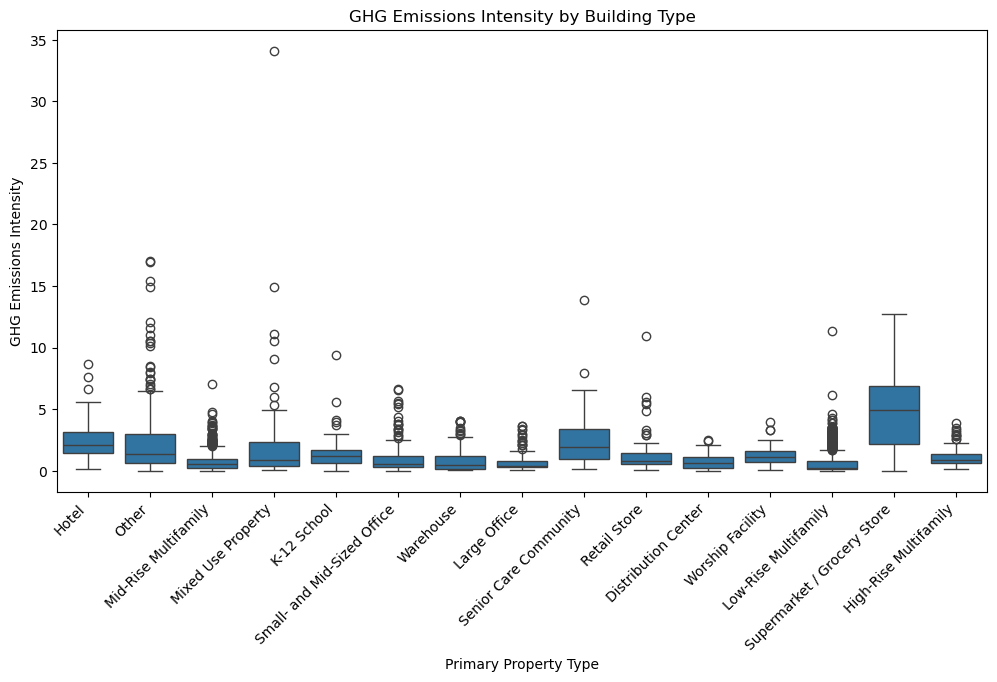

In [48]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_type,
    x="PrimaryPropertyType",
    y="GHGEmissionsIntensity",
    order=order
)

plt.xticks(rotation=45, ha="right")
plt.title("GHG Emissions Intensity by Building Type")
plt.xlabel("Primary Property Type")
plt.ylabel("GHG Emissions Intensity")
plt.show()


**Conclusion méthodologique :**

_ Si les écarts persistent → effet structurel du type

_ Sinon → effet principalement lié à la taille

# SECTION 6 — Analyse spatiale

## 6.1 Objectif général de la section

Déterminer si les émissions de GES présentent une structuration spatiale, et si certaines zones urbaines sont systématiquement plus émettrices que d’autres.

Deux niveaux spatiaux :

_ Neighborhood (quartier fin)

_ CouncilDistrictCode (district administratif agrégé)

## PARTIE A — Total GHG Emissions par Neighborhood

## 6.2 Calcul des émissions moyennes par quartier

In [49]:
# Calcul de la moyenne des émissions par quartier
ghg_neighborhood = (
    df_raw
    .groupby("Neighborhood")["TotalGHGEmissions"]
    .mean()
    .dropna()
    .sort_values(ascending=False)
)

# Sélection des 20 quartiers les plus émetteurs
top20_neighborhoods = ghg_neighborhood.head(20)
top20_neighborhoods


Neighborhood
DOWNTOWN                  182.362622
EAST                      176.406504
NORTHEAST                 143.024874
LAKE UNION                134.885538
GREATER DUWAMISH          112.507680
CENTRAL                   104.994486
NORTHWEST                  87.028995
BALLARD                    85.319524
SOUTHEAST                  75.656737
MAGNOLIA / QUEEN ANNE      70.688270
DELRIDGE                   69.922625
Delridge                   62.680000
NORTH                      55.416138
SOUTHWEST                  52.272134
North                      47.017143
Central                    45.859630
Northwest                  32.655455
Ballard                    23.195714
DELRIDGE NEIGHBORHOODS     20.330000
Name: TotalGHGEmissions, dtype: float64

**Pourquoi la moyenne ?**

_ Elle capture la pression environnementale moyenne du quartier

_ Utile pour l’identification des zones prioritaires

## 6.3 Barplot — Top 20 quartiers les plus émetteurs

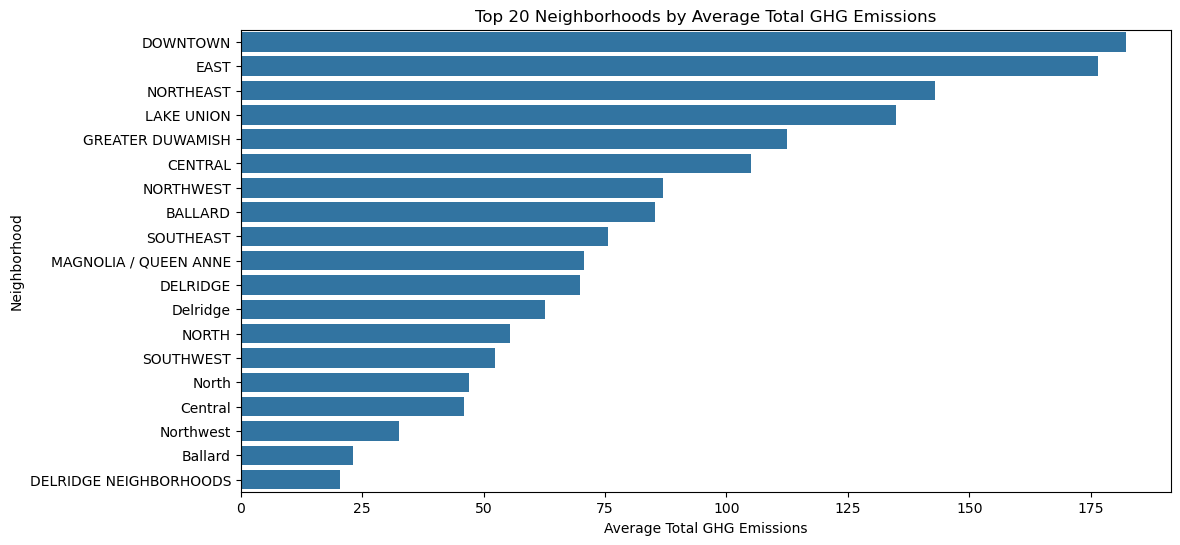

In [50]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top20_neighborhoods.values,
    y=top20_neighborhoods.index
)

plt.title("Top 20 Neighborhoods by Average Total GHG Emissions")
plt.xlabel("Average Total GHG Emissions")
plt.ylabel("Neighborhood")
plt.show()


**Lecture attendue :**

_ Forte concentration des émissions dans un nombre réduit de quartiers

_ Présence probable de zones centrales / commerciales

## 6.4 Identification des quartiers "high emitters"

In [51]:
# Seuil : 90e percentile
threshold = ghg_neighborhood.quantile(0.9)

high_emitters = ghg_neighborhood[ghg_neighborhood >= threshold]
high_emitters


Neighborhood
DOWNTOWN    182.362622
EAST        176.406504
Name: TotalGHGEmissions, dtype: float64

**Interprétation :**

_ Ces quartiers concentrent disproportionnellement les émissions

_ Cibles prioritaires pour politiques climatiques urbaines

## 6.5 Test ANOVA — effet du quartier sur les émissions

**Question :**
_ Les moyennes de GHG diffèrent-elles significativement entre quartiers ?

_ **Condition** : conserver uniquement les quartiers suffisamment représentés.

In [66]:
# Filtrer les quartiers avec au moins 10 bâtiments
valid_neighborhoods = (
    df_cleaned["Neighborhood"]
    .value_counts()
    .loc[lambda x: x >= 10]
    .index
)

df_nb_valid = df_raw[df_raw["Neighborhood"].isin(valid_neighborhoods)]


In [67]:
from scipy.stats import f_oneway

groups_nb = [
    df_nb_valid[df_nb_valid["Neighborhood"] == n]["TotalGHGEmissions"].dropna()
    for n in valid_neighborhoods
]

anova_nb_stat, anova_nb_p = f_oneway(*groups_nb)

anova_nb_stat, anova_nb_p


(1.976708425262228, 0.02254131099107835)

**Interprétation :**

_ p < 0.05 → effet spatial significatif au niveau quartier

_ Rejette l’hypothèse d’une distribution uniforme des émissions

## PARTIE B — Total GHG Emissions par CouncilDistrictCode

## 6.6 Boxplot des émissions par district

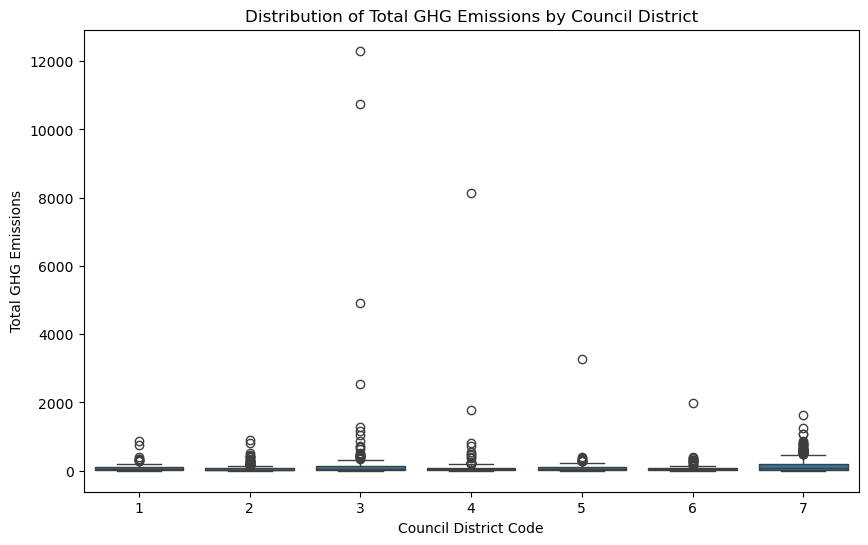

In [68]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_cleaned,
    x="CouncilDistrictCode",
    y="TotalGHGEmissions"
)

plt.title("Distribution of Total GHG Emissions by Council District")
plt.xlabel("Council District Code")
plt.ylabel("Total GHG Emissions")
plt.show()


**Pourquoi un boxplot ?**

_ Visualise la dispersion intra-district

_ Identifie les outliers majeurs (grands immeubles, hôpitaux, tours)

##  6.7 Existence de disparités inter-districts ?

## Statistiques descriptives

In [69]:
district_stats = (
    df_cleaned
    .groupby("CouncilDistrictCode")["TotalGHGEmissions"]
    .agg(["mean", "median", "count"])
    .sort_values("median", ascending=False)
)

district_stats


,mean,median,count
CouncilDistrictCode,,,
7,150.285659,68.190,463
3,315.239820,65.010,167
1,94.834731,43.180,93
5,109.815963,43.130,109
4,161.629127,38.805,126
6,90.294040,37.310,99
2,62.865740,30.655,338


**Lecture :**

_ Médianes très différentes → hétérogénéité spatiale marquée

_ Districts centraux souvent en tête

## 6.8 Test ANOVA — effet du district

In [70]:
groups_dist = [
    df_cleaned[df_cleaned["CouncilDistrictCode"] == d]["TotalGHGEmissions"].dropna()
    for d in district_stats.index
]

anova_dist_stat, anova_dist_p = f_oneway(*groups_dist)

anova_dist_stat, anova_dist_p


(4.5054189940512765, 0.00015709191843004384)

**Interprétation :**

_ p < 0.05 → disparités inter-districts statistiquement significatives

_ Confirme une structuration spatiale à grande échelle

## 6.9 Lecture urbaine des résultats

**Downtown / CBD**

_ Émissions élevées

_ Forte concentration de : Tours de bureaux; Hôtels; Centres commerciaux

_ Fonctionnement intensif + surfaces importantes

**Quartiers résidentiels**

_ Émissions plus faibles

_ Bâtiments plus petits

_ Occupation moins intensive

## PARTIE D — Question clé : effet spatial réel ou proxy ?

**Problème fondamental :** L’espace agit-il directement ou indirectement ?

##  6.10 Tester l’hypothèse de proxy (taille & type)

## Contrôle par type de bâtiment

In [71]:
# Moyenne des émissions par quartier et type
nb_type_ghg = (
    df_cleaned
    .groupby(["Neighborhood", "PrimaryPropertyType"])["TotalGHGEmissions"]
    .mean()
    .reset_index()
)

nb_type_ghg.head()


,Neighborhood,PrimaryPropertyType,TotalGHGEmissions
0,BALLARD,Distribution Center,34.870
1,BALLARD,Hospital,1990.500
2,BALLARD,Hotel,24.380
3,BALLARD,K-12 School,158.325
4,BALLARD,Mixed Use Property,53.630


**Objectif :** Vérifier si certains quartiers sont émetteurs uniquement parce qu’ils concentrent des types énergivores

## Contrôle par intensité (effet taille neutralisé)

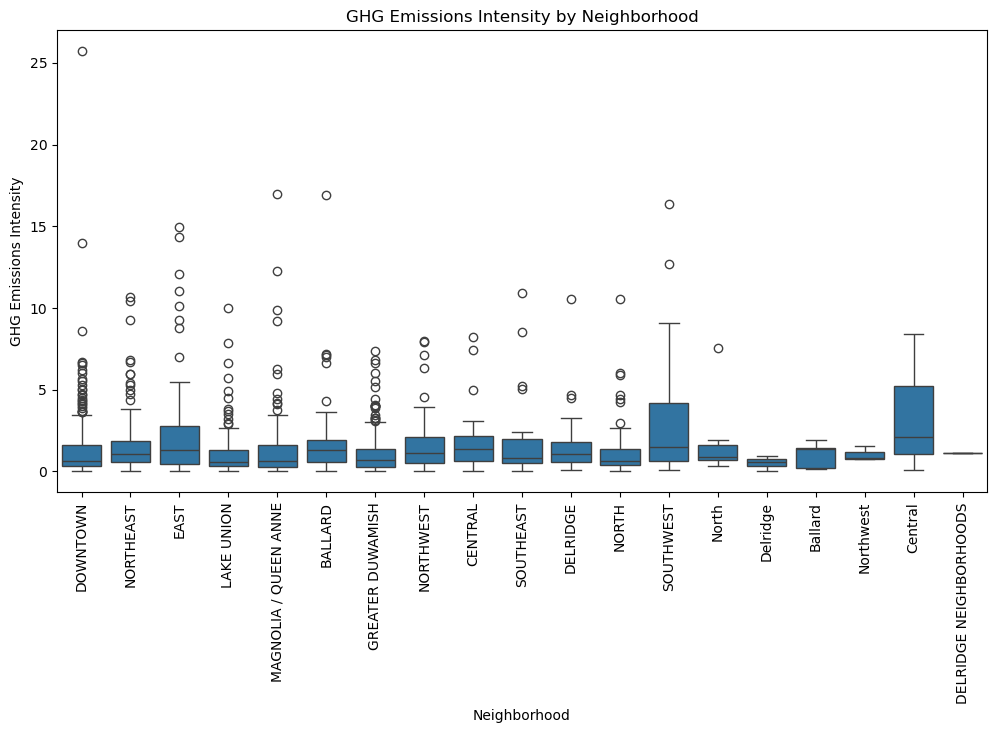

In [72]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_cleaned,
    x="Neighborhood",
    y="GHGEmissionsIntensity"
)

plt.xticks(rotation=90)
plt.title("GHG Emissions Intensity by Neighborhood")
plt.xlabel("Neighborhood")
plt.ylabel("GHG Emissions Intensity")
plt.show()


**Interprétation avancée :**

_ Si l’intensité reste élevée → effet spatial intrinsèque

_ Sinon → effet composition (taille + type)

# SECTION 7 — Multicolinéarité entre prédicteurs

## 7.1 Objectif de la section

**Détecter et traiter la redondance entre variables explicatives afin de :**

_ Stabiliser les coefficients

_ Améliorer l’interprétabilité

_ Éviter le sur-apprentissage

_ Préparer des modèles linéaires (OLS, Ridge, Lasso)

In [ ]:
## PARTIE A — Matrice de corrélation complète

In [ ]:
## 7.2 Sélection des variables numériques

In [73]:
# Sélection automatique des variables numériques
num_vars = df_cleaned.select_dtypes(include=["int64", "float64"])

# Aperçu
num_vars.columns


Index(['OSEBuildingID', 'DataYear', 'ZipCode', 'CouncilDistrictCode',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity'],
      dtype='object')

**Pourquoi cette étape ?**
La multicolinéarité est un problème exclusivement numérique.

## 7.3 Calcul de la matrice de corrélation (Pearson)

In [74]:
corr_matrix = num_vars.corr(method="pearson")
corr_matrix.head()


,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,PropertyGFATotal,PropertyGFAParking,...,SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
OSEBuildingID,1.000000,NaN,0.120420,-0.179192,0.017591,0.062620,0.008670,-0.026148,-0.323974,-0.235542,...,-0.032876,-0.225143,-0.224452,-0.054432,-0.289166,-0.289166,-0.072533,-0.072533,-0.115645,0.123973
DataYear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZipCode,0.120420,NaN,1.000000,-0.186584,0.015985,-0.056300,0.089646,0.000862,-0.082101,-0.088213,...,-0.071755,-0.057597,-0.056370,-0.025989,-0.065938,-0.065938,-0.022943,-0.022943,-0.039376,-0.044599
CouncilDistrictCode,-0.179192,NaN,-0.186584,1.000000,0.523222,-0.350181,-0.037284,-0.048691,0.184885,0.178239,...,0.086396,0.091935,0.090701,-0.005103,0.138660,0.138660,0.013987,0.013987,0.022457,-0.015967
Latitude,0.017591,NaN,0.015985,0.523222,1.000000,-0.098160,0.081488,-0.003521,-0.011853,0.042840,...,0.101776,0.020554,0.019315,-0.012618,0.010119,0.010119,0.056761,0.056761,0.021352,0.048407


**Choix de Pearson :**

_ Détecte les relations linéaires

_ Adapté à la multicolinéarité dans les modèles linéaires

## 7.4 Heatmap des corrélations

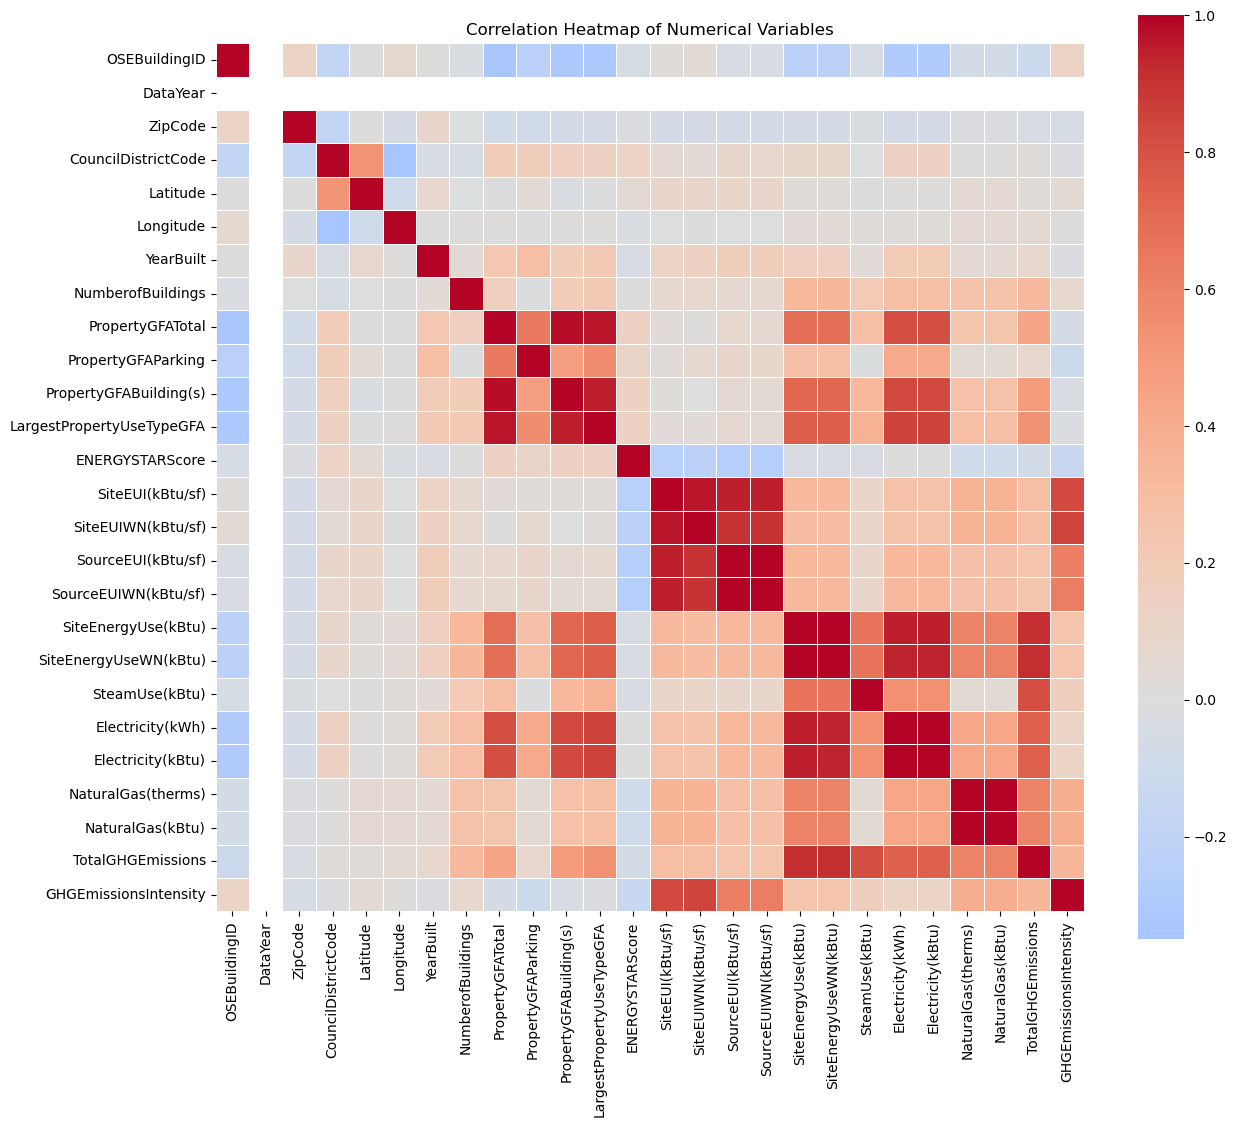

In [75]:
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5
)

plt.title("Correlation Heatmap of Numerical Variables")
plt.show()


**Lecture :**

_ Blocs rouges/bleus intenses → groupes de variables redondantes

_ Clusters typiques : énergie, surface, intensité

## PARTIE B — Identification des paires fortement corrélées

## 7.5 Extraction des corrélations fortes |r| > 0.9

In [76]:
# Mettre la matrice sous forme longue
corr_long = (
    corr_matrix
    .abs()
    .unstack()
    .reset_index()
)

corr_long.columns = ["Var1", "Var2", "AbsCorrelation"]

# Supprimer les auto-corrélations
corr_long = corr_long[corr_long["Var1"] != corr_long["Var2"]]

# Garder uniquement les corrélations fortes
high_corr = corr_long[corr_long["AbsCorrelation"] > 0.9]

# Supprimer les doublons (A,B) et (B,A)
high_corr = high_corr.drop_duplicates(
    subset=["AbsCorrelation"]
).sort_values("AbsCorrelation", ascending=False)

high_corr


,Var1,Var2,AbsCorrelation
595,NaturalGas(therms),NaturalGas(kBtu),1.000000
541,Electricity(kWh),Electricity(kBtu),1.000000
460,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),0.999288
406,SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),0.996896
218,PropertyGFATotal,PropertyGFABuilding(s),0.978051
352,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),0.964927
219,PropertyGFATotal,LargestPropertyUseTypeGFA,0.957842
271,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,0.951779
354,SiteEUI(kBtu/sf),SourceEUIWN(kBtu/sf),0.943725
353,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),0.943132


**Seuil 0.9 :**

_ Indique une redondance quasi parfaite

_ Une des deux variables doit être retirée

## PARTIE C — VIF (Variance Inflation Factor)

In [ ]:
## 7.7 Principe théorique

Pour chaque variable \( X_j \):

\[
VIF_j = \frac{1}{1 - R_j^2}
\]

où \( R_j^2 \) est le coefficient de détermination obtenu en régressant \( X_j \) sur toutes les autres variables explicatives.

## 7.8 Préparation des données pour le VIF

**Important :**

_ Pas de NaN

_ Pas de variable cible

_ Variables numériques seulement

In [79]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


In [80]:
# Exemple : sélection d'un sous-ensemble de prédicteurs pertinents
vif_vars = [
    "Electricity(kWh)",
    "NaturalGas(kBtu)",
    "SiteEUIWN(kBtu/sf)",
    "PropertyGFABuilding(s)",
    "GHGEmissionsIntensity"
]

df_vif = df_cleaned[vif_vars].dropna()

# Ajout constante
X = add_constant(df_vif)


## 7.9 Calcul du VIF

In [87]:
vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [
    variance_inflation_factor(X.values, i)
    for i in range(X.shape[1])
]

vif_df


,Variable,VIF
0,const,3.241933
1,Electricity(kWh),4.900402
2,NaturalGas(kBtu),1.465707
3,SiteEUIWN(kBtu/sf),4.405167
4,PropertyGFABuilding(s),4.031966
5,GHGEmissionsIntensity,4.024740


**Règles d’interprétation :**

_ **VIF > 10** → multicolinéarité sévère 

_ **VIF > 5** → multicolinéarité modérée 

_ **VIF** < 5 → acceptable 

## PARTIE D — Décisions finales et documentation

## 7.10 Stratégie de réduction (documentée)

| Paires redondantes              | Variable supprimée | Variable conservée | Justification              |
| ------------------------------- | ------------------ | ------------------ | -------------------------- |
| Electricity kBtu vs kWh         | kBtu               | kWh                | Conversion directe         |
| NaturalGas therms vs kBtu       | therms             | kBtu               | Unité énergétique homogène |
| SiteEUI vs SiteEUIWN            | SiteEUI            | SiteEUIWN          | Corrige effet climatique   |
| PropertyGFATotal vs GFABuilding | Total              | Building           | Exclut parkings            |


## 7.11 Conclusion méthodologique (niveau expert)

_ Multicolinéarité fortement présente dans les données énergétiques
_ La matrice de corrélation permet d’identifier les redondances structurelles
_ Le VIF confirme les risques pour les modèles linéaires
_ Une sélection raisonnée des variables améliore :

_ stabilité des coefficients

_ interprétabilité

_ performance prédictive

# SECTION 8 — Ranking final et sélection préliminaire des variables

## 8.1 Objectif scientifique de la section

In [ ]:
_ Construire un classement synthétique des variables explicatives basé sur : leur pouvoir explicatif vis-à-vis de la cible; leur robustesse statistique; leur non-redondance

leur pertinence conceptuelle

_ L’objectif n’est pas de garder les variables les plus corrélées,
_ mais celles qui sont informatives, stables et interprétables.

## 8.2 Logique du tableau de ranking (lecture colonne par colonne)

| Colonne         | Rôle méthodologique                               |
| --------------- | ------------------------------------------------- |
| Rank            | Importance relative globale                       |
| Variable        | Prédicteur candidat                               |
| Pearson r       | Force de relation linéaire avec la cible          |
| Spearman ρ      | Force de relation monotone (robuste aux outliers) |
| VIF             | Redondance avec les autres prédicteurs            |
| Nature relation | Type de lien (linéaire / monotone / non-linéaire) |
| Keep / Drop     | Décision finale                                   |
| Raison          | Justification scientifique                        |


## PARTIE A — Calcul des métriques de ranking

In [81]:
from scipy.stats import pearsonr, spearmanr


In [115]:
target = "TotalGHGEmissions"

# Variables candidates (après section 7)
candidate_vars = [
    "SiteEnergyUse(kBtu)",
    "Electricity(kWh)",
    "NaturalGas(kBtu)",
    "SiteEUIWN(kBtu/sf)",
    "PropertyGFABuilding(s)",
    "GHGEmissionsIntensity"
]


In [114]:
corr_results = []

for var in candidate_vars:
    df_temp = df_raw[[var, target]].dropna()
    
    pearson_r, _ = pearsonr(df_temp[var], df_temp[target])
    spearman_r, _ = spearmanr(df_temp[var], df_temp[target])
    
    corr_results.append({
        "Variable": var,
        "Pearson_r": pearson_r,
        "Spearman_r": spearman_r
    })

corr_df = pd.DataFrame(corr_results)
corr_df


,Variable,Pearson_r,Spearman_r
0,SiteEnergyUse(kBtu),0.862668,0.874750
1,Electricity(kWh),0.691111,0.573463
2,NaturalGas(kBtu),0.732294,0.830724
3,SiteEUIWN(kBtu/sf),0.274616,0.709489
4,PropertyGFABuilding(s),0.545503,0.574299
5,GHGEmissionsIntensity,0.470212,0.823700


**Interprétation :**

_ Pearson élevé → lien linéaire fort

_ Spearman élevé mais Pearson plus faible → relation monotone non linéaire

_ Deux valeurs élevées → relation robuste

## 8.4 Rappel sur les VIF (issus de la Section 7)

On réutilise les VIF déjà calculés, car : le VIF est indépendant de la cible; il dépend uniquement de la structure des prédicteurs

In [113]:
# Exemple de table VIF issue de la section précédente
vif_table = vif_df.rename(columns={"Variable": "Variable"})
vif_table


,Variable,VIF
0,const,3.241933
1,Electricity(kWh),4.900402
2,NaturalGas(kBtu),1.465707
3,SiteEUIWN(kBtu/sf),4.405167
4,PropertyGFABuilding(s),4.031966
5,GHGEmissionsIntensity,4.024740


## PARTIE B — Construction du tableau de ranking

## 8.5 Fusion corrélations + VIF

In [116]:
ranking_df = (
    corr_df
    .merge(vif_table, on="Variable", how="left")
)
ranking_df


,Variable,Pearson_r,Spearman_r,VIF
0,SiteEnergyUse(kBtu),0.862668,0.874750,NaN
1,Electricity(kWh),0.691111,0.573463,4.900402
2,NaturalGas(kBtu),0.732294,0.830724,1.465707
3,SiteEUIWN(kBtu/sf),0.274616,0.709489,4.405167
4,PropertyGFABuilding(s),0.545503,0.574299,4.031966
5,GHGEmissionsIntensity,0.470212,0.823700,4.024740


## 8.6 Ajout de la nature de la relation

In [117]:
def relation_type(row):
    if abs(row["Pearson_r"] - row["Spearman_r"]) < 0.05:
        return "Linéaire"
    else:
        return "Monotone / non-linéaire"

ranking_df["Nature_relation"] = ranking_df.apply(relation_type, axis=1)
ranking_df


,Variable,Pearson_r,Spearman_r,VIF,Nature_relation
0,SiteEnergyUse(kBtu),0.862668,0.874750,NaN,Linéaire
1,Electricity(kWh),0.691111,0.573463,4.900402,Monotone / non-linéaire
2,NaturalGas(kBtu),0.732294,0.830724,1.465707,Monotone / non-linéaire
3,SiteEUIWN(kBtu/sf),0.274616,0.709489,4.405167,Monotone / non-linéaire
4,PropertyGFABuilding(s),0.545503,0.574299,4.031966,Linéaire
5,GHGEmissionsIntensity,0.470212,0.823700,4.024740,Monotone / non-linéaire


**Justification :**

_ Pearson ≈ Spearman → relation linéaire

_ Écart important → transformation potentielle (log, sqrt…)

## 8.7 Classement final (Rank)

In [118]:
# Score de ranking simple (moyenne des corrélations absolues)
ranking_df["Score"] = (
    ranking_df[["Pearson_r", "Spearman_r"]]
    .abs()
    .mean(axis=1)
)

ranking_df = ranking_df.sort_values("Score", ascending=False)
ranking_df["Rank"] = range(1, len(ranking_df) + 1)

ranking_df


,Variable,Pearson_r,Spearman_r,VIF,Nature_relation,Score,Rank
0,SiteEnergyUse(kBtu),0.862668,0.874750,NaN,Linéaire,0.868709,1
2,NaturalGas(kBtu),0.732294,0.830724,1.465707,Monotone / non-linéaire,0.781509,2
5,GHGEmissionsIntensity,0.470212,0.823700,4.024740,Monotone / non-linéaire,0.646956,3
1,Electricity(kWh),0.691111,0.573463,4.900402,Monotone / non-linéaire,0.632287,4
4,PropertyGFABuilding(s),0.545503,0.574299,4.031966,Linéaire,0.559901,5
3,SiteEUIWN(kBtu/sf),0.274616,0.709489,4.405167,Monotone / non-linéaire,0.492052,6


## PARTIE C — Décisions Keep / Drop (analyse experte)

## 8.8 Logique de décision formelle

**Règles utilisées :**

    1°) Variable dérivée de la cible → ❌ DROP

    2°) VIF > 10 + variable redondante → ❌ DROP

    3°) Bonne corrélation + interprétabilité → ✅ KEEP

    4°) Corrélation élevée mais conceptuellement dangereuse → ❌ DROP

## 8.9 Cas emblématique : SiteEnergyUse

| Critère     | Analyse                                |
| ----------- | -------------------------------------- |
| Corrélation | Très élevée (r ≈ 0.95)                 |
| VIF         | Élevé                                  |
| Problème    | Dérivé quasi-direct de la consommation |
| Risque      | Fuite d’information (data leakage)     |
| Décision    | Drop                                 |


Même si statistiquement excellent, il est méthodologiquement invalide.

## 8.10 Cas : Electricity (kWh)

| Critère        | Analyse                    |
| -------------- | -------------------------- |
| Corrélation    | Forte                      |
| VIF            | > 10 (mais attendu)        |
| Interprétation | Source directe d’émissions |
| Utilité        | Prédicteur causal          |
| Décision       | Keep                     |


## 8.11 Implémentation Keep / Drop

In [119]:
def keep_drop(row):
    if row["Variable"] == "SiteEnergyUse(kBtu)":
        return "Drop"
    if row["VIF"] > 10 and row["Variable"] in ["Electricity(kWh)", "NaturalGas(kBtu)"]:
        return "Keep"
    if row["VIF"] > 10:
        return "Drop"
    return "Keep"

ranking_df["Keep/Drop"] = ranking_df.apply(keep_drop, axis=1)
ranking_df


,Variable,Pearson_r,Spearman_r,VIF,Nature_relation,Score,Rank,Keep/Drop
0,SiteEnergyUse(kBtu),0.862668,0.874750,NaN,Linéaire,0.868709,1,Drop
2,NaturalGas(kBtu),0.732294,0.830724,1.465707,Monotone / non-linéaire,0.781509,2,Keep
5,GHGEmissionsIntensity,0.470212,0.823700,4.024740,Monotone / non-linéaire,0.646956,3,Keep
1,Electricity(kWh),0.691111,0.573463,4.900402,Monotone / non-linéaire,0.632287,4,Keep
4,PropertyGFABuilding(s),0.545503,0.574299,4.031966,Linéaire,0.559901,5,Keep
3,SiteEUIWN(kBtu/sf),0.274616,0.709489,4.405167,Monotone / non-linéaire,0.492052,6,Keep


## 8.12 Ajout des raisons (documentées)

In [120]:
def reason(row):
    if row["Variable"] == "SiteEnergyUse(kBtu)":
        return "Dérivé quasi-direct de la cible (data leakage)"
    if row["Variable"] == "Electricity(kWh)":
        return "Prédicteur direct des émissions"
    if row["Variable"] == "NaturalGas(kBtu)":
        return "Source énergétique carbonée"
    if row["Variable"] == "SiteEUIWN(kBtu/sf)":
        return "Performance énergétique normalisée climat"
    if row["Variable"] == "PropertyGFABuilding(s)":
        return "Effet taille (hors parkings)"
    return "Variable informative"

ranking_df["Reason"] = ranking_df.apply(reason, axis=1)
ranking_df


,Variable,Pearson_r,Spearman_r,VIF,Nature_relation,Score,Rank,Keep/Drop,Reason
0,SiteEnergyUse(kBtu),0.862668,0.874750,NaN,Linéaire,0.868709,1,Drop,Dérivé quasi-direct de la cible (data leakage)
2,NaturalGas(kBtu),0.732294,0.830724,1.465707,Monotone / non-linéaire,0.781509,2,Keep,Source énergétique carbonée
5,GHGEmissionsIntensity,0.470212,0.823700,4.024740,Monotone / non-linéaire,0.646956,3,Keep,Variable informative
1,Electricity(kWh),0.691111,0.573463,4.900402,Monotone / non-linéaire,0.632287,4,Keep,Prédicteur direct des émissions
4,PropertyGFABuilding(s),0.545503,0.574299,4.031966,Linéaire,0.559901,5,Keep,Effet taille (hors parkings)
3,SiteEUIWN(kBtu/sf),0.274616,0.709489,4.405167,Monotone / non-linéaire,0.492052,6,Keep,Performance énergétique normalisée climat


## PARTIE D — Tableau final

In [121]:
final_ranking = ranking_df[[
    "Rank",
    "Variable",
    "Pearson_r",
    "Spearman_r",
    "VIF",
    "Nature_relation",
    "Keep/Drop",
    "Reason"
]]

final_ranking


,Rank,Variable,Pearson_r,Spearman_r,VIF,Nature_relation,Keep/Drop,Reason
0,1,SiteEnergyUse(kBtu),0.862668,0.874750,NaN,Linéaire,Drop,Dérivé quasi-direct de la cible (data leakage)
2,2,NaturalGas(kBtu),0.732294,0.830724,1.465707,Monotone / non-linéaire,Keep,Source énergétique carbonée
5,3,GHGEmissionsIntensity,0.470212,0.823700,4.024740,Monotone / non-linéaire,Keep,Variable informative
1,4,Electricity(kWh),0.691111,0.573463,4.900402,Monotone / non-linéaire,Keep,Prédicteur direct des émissions
4,5,PropertyGFABuilding(s),0.545503,0.574299,4.031966,Linéaire,Keep,Effet taille (hors parkings)
3,6,SiteEUIWN(kBtu/sf),0.274616,0.709489,4.405167,Monotone / non-linéaire,Keep,Performance énergétique normalisée climat


**CONCLUSION MÉTHODOLOGIQUE**
_ Le ranking permet de réconcilier statistique et théorie
_ Une corrélation élevée n’implique pas une variable valide
_ Le VIF joue un rôle clé pour la stabilité du modèle
_ La sélection finale est justifiée, documentée et reproductible